Loading Florentine Families Network...
 at (1, 1)loading: cannot tokenize <!DOCTYPE html>
Using NetworkX built-in Florentine families graph...

Loaded: 15 families, 20 business relationships

Historical Factions: 3
  Faction 0: 6 families - ['Medici', 'Tornabuoni', 'Acciaiuoli']
  Faction 1: 7 families - ['Strozzi', 'Albizzi', 'Bardi']
  Faction 2: 2 families - ['Pazzi', 'Salviati']


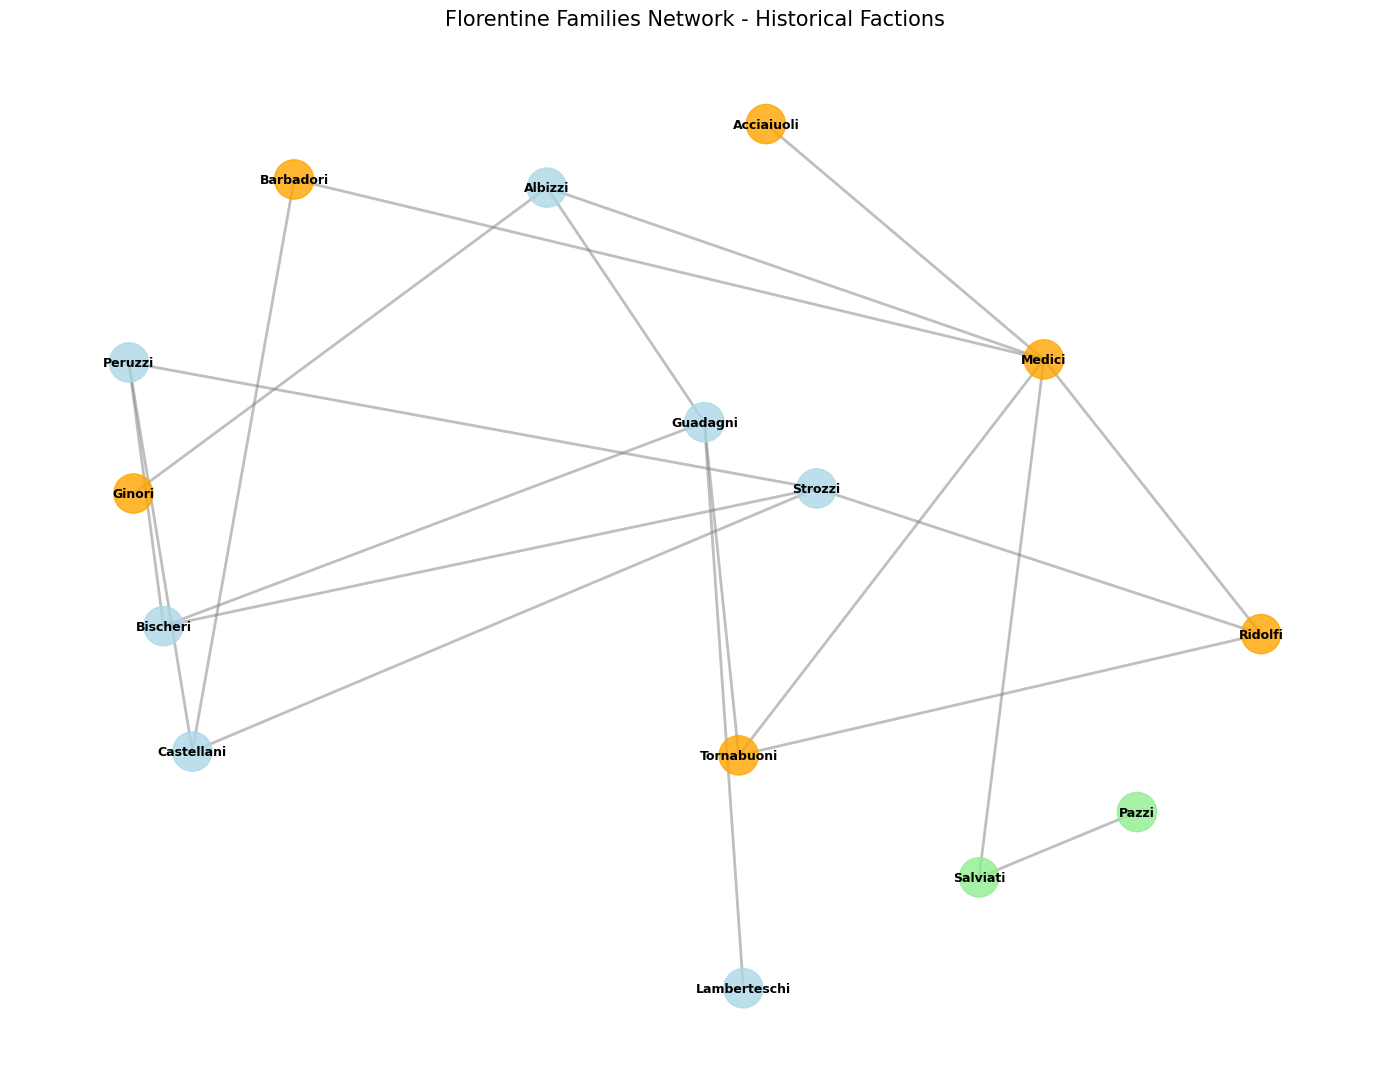


Running Girvan-Newman Algorithm...

Community detection progress:
Level 1:  2 communities, Modularity = 0.0888
Level 2:  3 communities, Modularity = 0.3513
Level 3:  4 communities, Modularity = 0.3975
Level 4:  5 communities, Modularity = 0.3800
Level 5:  6 communities, Modularity = 0.3550
Level 6:  7 communities, Modularity = 0.3200
Level 7:  8 communities, Modularity = 0.2575
Level 8:  9 communities, Modularity = 0.2025
Level 9: 10 communities, Modularity = 0.1288
Level 10: 11 communities, Modularity = 0.0938
Level 11: 12 communities, Modularity = 0.0550
Level 12: 13 communities, Modularity = 0.0088
Level 13: 14 communities, Modularity = -0.0388
Level 14: 15 communities, Modularity = -0.0838

Best partition: 4 communities, Modularity = 0.3975
Community sizes: [5, 4, 4, 2]

✅ Exported GEXF file with communities → florentine_with_communities.gexf

EVALUATION METRICS

Clustering Metrics:
  NMI: 0.5785
  ARI: 0.3606

Classification Metrics (after alignment):
  Accuracy:  0.7333
  Precis

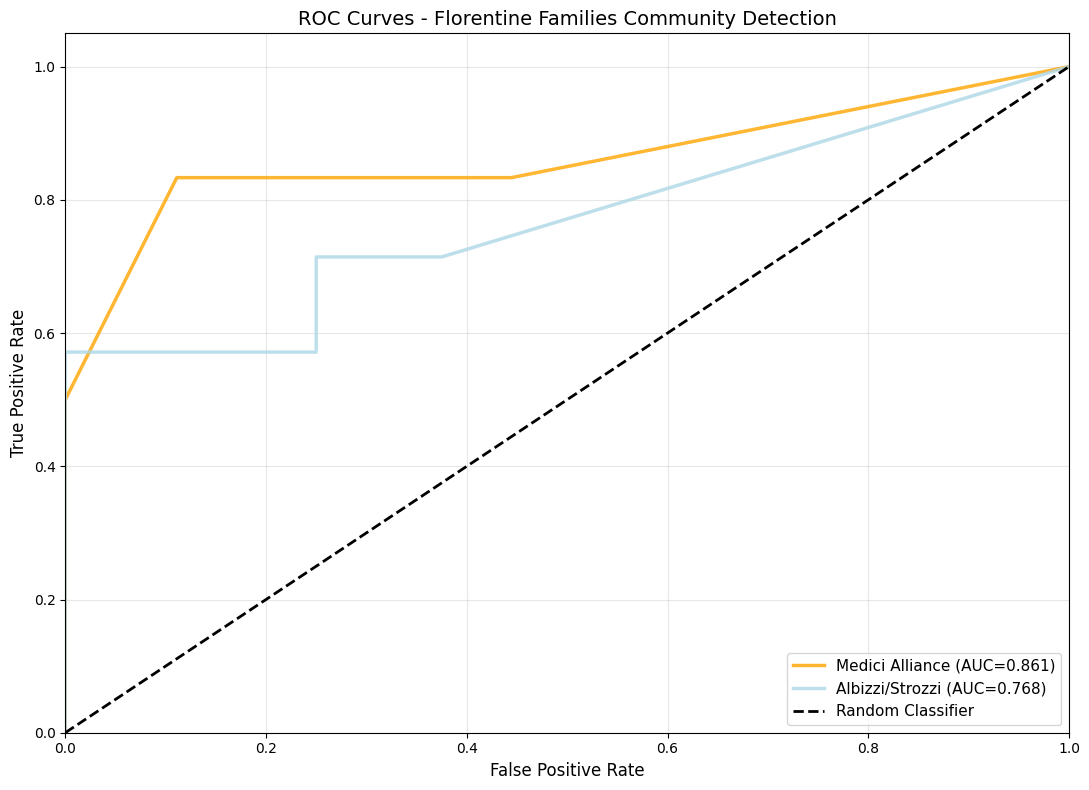

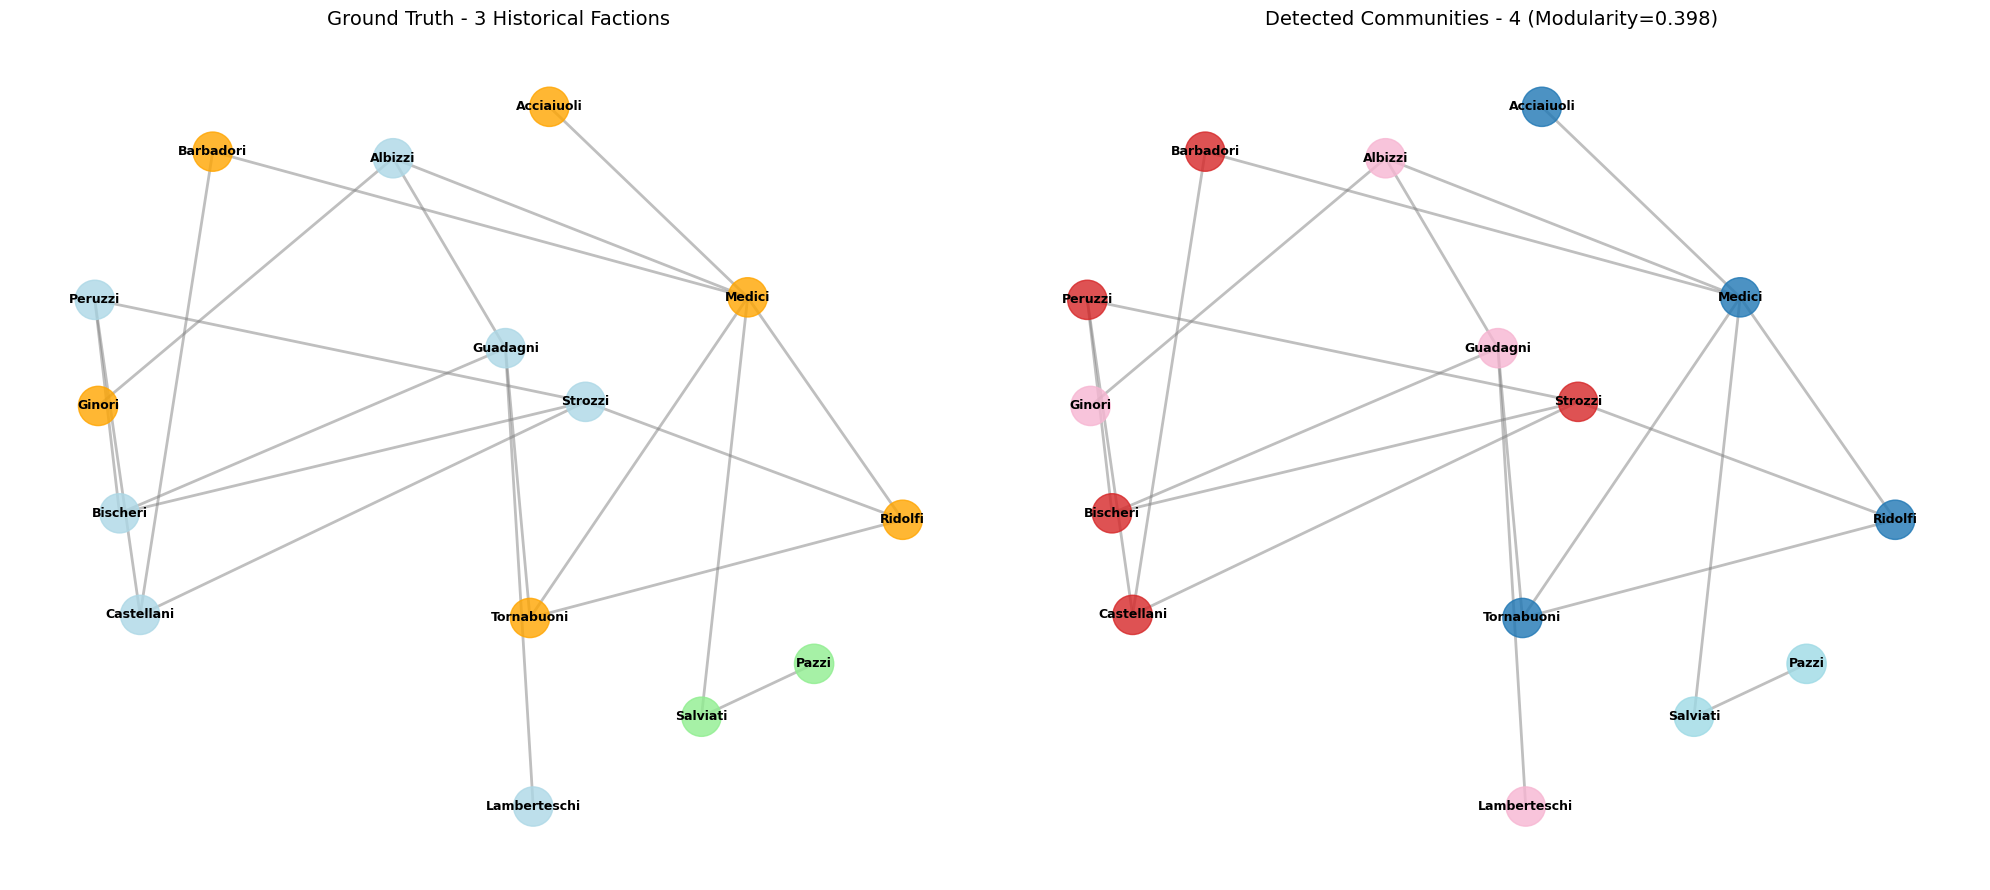

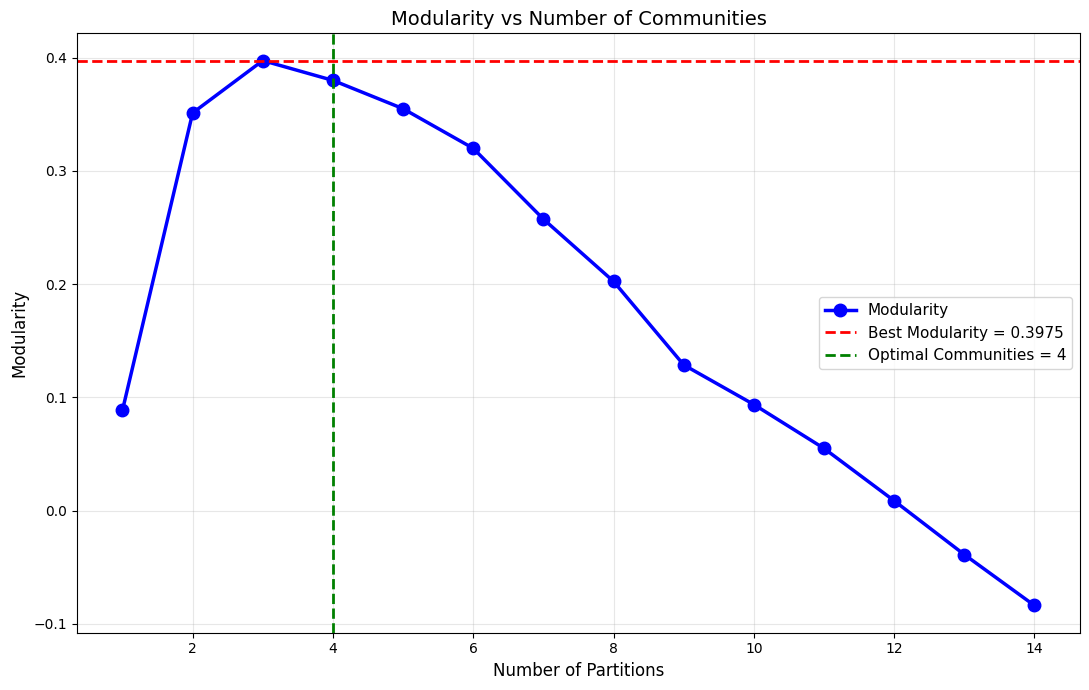


ANALYSIS COMPLETE!

Summary:
  Florentine Families: 15
  Business Relationships: 20
  Historical Factions: 3
  Detected Communities: 4
  Best Modularity: 0.3975
  NMI: 0.5785
  ARI: 0.3606
  Accuracy: 0.7333
  Mean AUC: 0.8145


In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from networkx.algorithms.community import girvan_newman
from networkx.algorithms.community.quality import modularity
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                            roc_curve, auc, normalized_mutual_info_score, adjusted_rand_score)
from scipy.optimize import linear_sum_assignment
import numpy as np
import urllib.request
import tempfile
import os

# ============================================================================ #
# LOAD FLORENTINE FAMILIES NETWORK
# ============================================================================ #
print("Loading Florentine Families Network...")

try:
    G = nx.read_gml('florentine_families.gml')
    print("Loaded from local file")
except:
    try:
        url = 'http://www-personal.umich.edu/~mejn/netdata/florentine_families_business.gml'
        with tempfile.NamedTemporaryFile(mode='w', delete=False, suffix='.gml') as tmp:
            with urllib.request.urlopen(url) as response:
                tmp.write(response.read().decode('utf-8'))
            tmp_path = tmp.name
        G = nx.read_gml(tmp_path)
        os.remove(tmp_path)
        print("Downloaded from URL")
    except Exception as e:
        print(f"Error downloading: {e}")
        print("Using NetworkX built-in Florentine families graph...")
        G = nx.florentine_families_graph()

print(f"\nLoaded: {G.number_of_nodes()} families, {G.number_of_edges()} business relationships")

# ============================================================================ #
# HISTORICAL FACTIONS (GROUND TRUTH)
# ============================================================================ #
node_list = list(G.nodes())
factions = {
    'Medici': 0, 'Strozzi': 1, 'Albizzi': 1, 'Pazzi': 2, 'Salviati': 2, 'Tornabuoni': 0,
    'Bardi': 1, 'Peruzzi': 1, 'Acciaiuoli': 0, 'Barbadori': 0, 'Castellani': 1,
    'Ginori': 0, 'Guadagni': 1, 'Lamberteschi': 1, 'Ridolfi': 0, 'Uzano': 1,
    'Pucci': 0, 'Macinghi': 1, 'Corsini': 0, 'Capponi': 1
}

ground_truth = [factions.get(node, 1) for node in node_list]
n_groups = len(set(ground_truth))
print(f"\nHistorical Factions: {n_groups}")
for faction_id in sorted(set(ground_truth)):
    count = sum(1 for g in ground_truth if g == faction_id)
    faction_names = [name for name, fid in factions.items() if fid == faction_id]
    print(f"  Faction {faction_id}: {count} families - {faction_names[:3]}")

# ============================================================================ #
# VISUALIZE INITIAL NETWORK
# ============================================================================ #
pos = nx.spring_layout(G, k=2, iterations=50, seed=42)
faction_colors = {0: 'orange', 1: 'lightblue', 2: 'lightgreen'}
colors_true = [faction_colors[ground_truth[i]] for i in range(len(node_list))]

plt.figure(figsize=(14, 11))
nx.draw_networkx_nodes(G, pos, node_color=colors_true, node_size=800, alpha=0.8)
nx.draw_networkx_edges(G, pos, width=2, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(G, pos, font_size=9, font_weight='bold')
plt.title("Florentine Families Network - Historical Factions", fontsize=15)
plt.axis('off')
plt.tight_layout()
plt.show()

# ============================================================================ #
# APPLY GIRVAN-NEWMAN
# ============================================================================ #
print("\n" + "="*70)
print("Running Girvan-Newman Algorithm...")
print("="*70)

comp = girvan_newman(G)
best_mod, best_part = -1, None
mods = []

print("\nCommunity detection progress:")
for i, comms in enumerate(comp):
    mod = modularity(G, comms)
    mods.append(mod)
    n_comms = len(comms)
    print(f"Level {i+1}: {n_comms:2d} communities, Modularity = {mod:.4f}")
    
    if mod > best_mod:
        best_mod, best_part = mod, comms
    
    if n_comms >= 15 or i >= 20:
        break

predicted = np.zeros(len(node_list), dtype=int)
for i, comm in enumerate(best_part):
    for node in comm:
        predicted[node_list.index(node)] = i

print(f"\n{'='*70}")
print(f"Best partition: {len(best_part)} communities, Modularity = {best_mod:.4f}")
print(f"Community sizes: {sorted([len(c) for c in best_part], reverse=True)}")
print(f"{'='*70}")

# ============================================================================ #
# EXPORT TO GEXF (FOR GEPHI)
# ============================================================================ #
def export_to_gexf(G, communities, filename="florentine_with_communities.gexf"):
    """Export Florentine network with community labels to GEXF."""
    for i, comm in enumerate(communities):
        for node in comm:
            G.nodes[node]['community'] = i + 1  # assign community IDs
    nx.write_gexf(G, filename)
    print(f"\n✅ Exported GEXF file with communities → {filename}")

export_to_gexf(G, best_part, "florentine_with_communities.gexf")

# ============================================================================ #
# METRICS
# ============================================================================ #
print("\n" + "="*70)
print("EVALUATION METRICS")
print("="*70)

nmi = normalized_mutual_info_score(ground_truth, predicted)
ari = adjusted_rand_score(ground_truth, predicted)

print(f"\nClustering Metrics:")
print(f"  NMI: {nmi:.4f}")
print(f"  ARI: {ari:.4f}")

contingency = np.zeros((n_groups, len(best_part)))
for i in range(len(node_list)):
    contingency[ground_truth[i], predicted[i]] += 1

row_ind, col_ind = linear_sum_assignment(-contingency)
aligned = np.zeros_like(predicted)
for true_label, pred_label in zip(row_ind, col_ind):
    aligned[predicted == pred_label] = true_label

acc = accuracy_score(ground_truth, aligned)
prec = precision_score(ground_truth, aligned, average='weighted', zero_division=0)
rec = recall_score(ground_truth, aligned, average='weighted', zero_division=0)
f1 = f1_score(ground_truth, aligned, average='weighted', zero_division=0)

print(f"\nClassification Metrics (after alignment):")
print(f"  Accuracy:  {acc:.4f}")
print(f"  Precision: {prec:.4f}")
print(f"  Recall:    {rec:.4f}")
print(f"  F1-Score:  {f1:.4f}")

# ============================================================================ #
# ROC CURVE
# ============================================================================ #
def get_probs(G, node_list, communities):
    prob_matrix = np.zeros((len(node_list), len(communities)))
    comm_sets = [set(c) for c in communities]
    
    for i, node in enumerate(node_list):
        neighbors = list(G.neighbors(node))
        if neighbors:
            for j, comm_set in enumerate(comm_sets):
                edges_to_comm = sum(1 for n in neighbors if n in comm_set)
                prob_matrix[i, j] = edges_to_comm / len(neighbors)
        else:
            prob_matrix[i, :] = 1.0 / len(communities)
    return prob_matrix

probs = get_probs(G, node_list, best_part)
label_map = {v: k for k, v in zip(row_ind, col_ind)}

aucs = []
plt.figure(figsize=(11, 8))
faction_names_map = {0: 'Medici Alliance', 1: 'Albizzi/Strozzi', 2: 'Pazzi/Salviati'}
colors_roc = ['orange', 'lightblue', 'lightgreen']

for class_id in range(n_groups):
    y_true = (np.array(ground_truth) == class_id).astype(int)
    if np.sum(y_true) < 2 or class_id not in label_map:
        continue
    
    y_score = probs[:, label_map[class_id]]
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    aucs.append(roc_auc)
    
    faction_name = faction_names_map.get(class_id, f"Faction {class_id}")
    plt.plot(fpr, tpr, lw=2.5, alpha=0.8, color=colors_roc[class_id],
             label=f'{faction_name} (AUC={roc_auc:.3f})')

if aucs:
    mean_auc = np.mean(aucs)
    print(f"\n" + "="*70)
    print(f"ROC AUC Metrics:")
    print(f"  Mean AUC: {mean_auc:.4f}")
    print(f"  Individual AUCs: {[f'{a:.3f}' for a in aucs]}")
    print(f"="*70)
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curves - Florentine Families Community Detection', fontsize=14)
    plt.legend(loc="lower right", fontsize=11)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

# ============================================================================ #
# VISUALIZATIONS
# ============================================================================ #
colors_pred = plt.cm.tab20(np.linspace(0, 1, len(best_part)))
colors_pred_map = [colors_pred[predicted[i]] for i in range(len(node_list))]

fig, axes = plt.subplots(1, 2, figsize=(20, 9))

nx.draw_networkx_nodes(G, pos, ax=axes[0], node_color=colors_true, node_size=800, alpha=0.8)
nx.draw_networkx_edges(G, pos, ax=axes[0], width=2, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(G, pos, ax=axes[0], font_size=9, font_weight='bold')
axes[0].set_title(f"Ground Truth - {n_groups} Historical Factions", fontsize=14)
axes[0].axis('off')

nx.draw_networkx_nodes(G, pos, ax=axes[1], node_color=colors_pred_map, node_size=800, alpha=0.8)
nx.draw_networkx_edges(G, pos, ax=axes[1], width=2, alpha=0.5, edge_color='gray')
nx.draw_networkx_labels(G, pos, ax=axes[1], font_size=9, font_weight='bold')
axes[1].set_title(f"Detected Communities - {len(best_part)} (Modularity={best_mod:.3f})", fontsize=14)
axes[1].axis('off')

plt.tight_layout()
plt.show()

# ============================================================================ #
# MODULARITY PROGRESSION
# ============================================================================ #
plt.figure(figsize=(11, 7))
plt.plot(range(1, len(mods)+1), mods, 'bo-', linewidth=2.5, markersize=9, label='Modularity')
plt.axhline(y=best_mod, color='r', linestyle='--', linewidth=2, 
            label=f'Best Modularity = {best_mod:.4f}')
plt.axvline(x=len(best_part), color='g', linestyle='--', linewidth=2,
            label=f'Optimal Communities = {len(best_part)}')
plt.xlabel('Number of Partitions', fontsize=12)
plt.ylabel('Modularity', fontsize=12)
plt.title('Modularity vs Number of Communities', fontsize=14)
plt.grid(alpha=0.3)
plt.legend(fontsize=11)
plt.tight_layout()
plt.show()

# ============================================================================ #
# FINAL SUMMARY
# ============================================================================ #
print("\n" + "="*70)
print("ANALYSIS COMPLETE!")
print("="*70)
print(f"\nSummary:")
print(f"  Florentine Families: {len(node_list)}")
print(f"  Business Relationships: {G.number_of_edges()}")
print(f"  Historical Factions: {n_groups}")
print(f"  Detected Communities: {len(best_part)}")
print(f"  Best Modularity: {best_mod:.4f}")
print(f"  NMI: {nmi:.4f}")
print(f"  ARI: {ari:.4f}")
print(f"  Accuracy: {acc:.4f}")
if aucs:
    print(f"  Mean AUC: {mean_auc:.4f}")
print("="*70)
